# **Residential Property Valuation: The Case of Cook County, US**


Accurate property valuation is a common problem faced by every city government. It is a requirement for the collection of property tax and necessary for the development of an area. Poor valuation will give rise to illicit activities, under the table transactions and underutilization. 

Most houses are not sold, thus their market value must be extrapolated from sold houses. This becomes a fertile problem for the application of statistical methods and machine learning. We tackle this problem using two large datasets on Residential Sales & Property Characteristics obtained from Cook County in the US.

1. Sale of Houses from 2013-2019, with Characteristics. (500k Records)
2. Residential Property Characteristics of all houses. (2Mn Records)

[A full description of the data](https://datacatalog.cookcountyil.gov/stories/s/p2kt-hk36).

In [1]:
# Load Data
PATH = '/content/drive/My Drive/Projects/Machine Learning/Real World Problems/Residential Property Valuation/Data/'
import pandas as pd, numpy as np
df = pd.read_csv(PATH + 'sales.csv').sample(frac=0.1)

# Rename Columns
df.columns = ['PIN'] + [''.join([j for j in i.title() if j.isalnum()]) for i in df.columns[1:]]
firstCols = ['PIN', 'PropertyClass', 'SaleDate', 'SalePrice', 'EstimateBuilding', 'PureMarketFilter', 'BuildingSquareFeet', 'LandSquareFeet' ]
df = df[firstCols + [i for i in df.columns if i not in firstCols]]

df.head()

,PIN,PropertyClass,SaleDate,SalePrice,EstimateBuilding,PureMarketFilter,BuildingSquareFeet,LandSquareFeet,NeighborhoodCode,TownCode,TypeOfResidence,Apartments,WallMaterial,RoofMaterial,Rooms,Bedrooms,Basement,BasementFinish,CentralHeating,OtherHeating,CentralAir,Fireplaces,AtticType,AtticFinish,HalfBaths,DesignPlan,CathedralCeiling,ConstructionQuality,Renovation,SiteDesirability,Garage1Size,Garage1Material,Garage1Attachment,Garage1Area,Garage2Size,Garage2Material,Garage2Attachment,Garage2Area,Porch,OtherImprovements,...,EstimateLand,DeedNo,Longitude,Latitude,CensusTract,TotalBuildingSquareFeet,MultiPropertyIndicator,PropertyAddress,ModelingGroup,FullBaths,Age,Use,NumberOfUnits,PercentOwnership,CondoClassFactor,MultiFamilyIndicator,LargeLot,ConditionDesirabilityAndUtility,OHareNoise,Floodplain,RoadProximity,CondoStrata,SaleYear,SaleQuarter,SaleHalfYear,SaleQuarterOfYear,SaleMonthOfYear,SaleHalfOfYear,MostRecentSale,AgeSquared,AgeDecade,AgeDecadeSquared,LotSizeSquared,ImprovementSizeSquared,GarageIndicator,NeigborhoodCodeMapping,SquareRootOfLotSize,SquareRootOfAge,SquareRootOfImprovementSize,TownAndNeighborhood
340910,30204090100000,203,02/25/2015,27000,60190,1,1138.0,4760.0,101,37,5.0,0.0,3.0,1.0,4.0,2.0,1.0,3.0,2.0,5.0,0.0,0.0,1.0,1,0.0,2.0,0.0,2.0,NaN,2.0,3.0,1.0,2.0,2.0,7.0,0.0,0.0,0.0,3,0.0,...,15470,1505601030,-87.528277,41.588988,826202.0,NaN,0,1531 KENILWORTH DR,SF,1.0,65,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,NaN,2015,73,37,1,2,1,0.0,4225,6.5,42.25,2.265760e+07,1295044.0,1.0,101,68.992753,8.062258,33.734256,37101
395458,17284010340000,211,08/30/2016,415000,264420,1,3339.0,2640.0,30,76,3.0,3.0,2.0,2.0,18.0,6.0,4.0,3.0,2.0,5.0,0.0,0.0,3.0,0,0.0,2.0,0.0,2.0,NaN,2.0,3.0,2.0,2.0,2.0,7.0,0.0,0.0,0.0,3,0.0,...,92400,1624310108,-87.634863,41.844273,340300.0,NaN,0,312 W 27TH ST,MF,3.0,137,2,NaN,NaN,NaN,211.0,NaN,NaN,0.0,0.0,0.0,NaN,2016,79,40,3,8,2,1.0,18769,13.7,187.69,6.969600e+06,11148921.0,1.0,30,51.380930,11.704700,57.784081,7630
205507,10232160640000,203,12/12/2013,345000,214540,1,1346.0,4920.0,81,24,1.0,0.0,2.0,1.0,6.0,3.0,3.0,3.0,1.0,2.0,0.0,0.0,3.0,0,0.0,0.0,0.0,2.0,NaN,2.0,3.0,1.0,2.0,2.0,7.0,0.0,0.0,0.0,3,0.0,...,40590,1334635046,-87.714261,42.036871,807200.0,NaN,0,8549 TRUMBULL AVE,SF,1.0,51,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,2013,68,34,4,12,2,1.0,2601,5.1,26.01,2.420640e+07,1811716.0,1.0,81,70.142712,7.141428,36.687873,2481
512443,13292140240000,203,06/13/2016,176500,158500,1,1048.0,3720.0,200,71,1.0,0.0,1.0,1.0,4.0,2.0,2.0,3.0,1.0,5.0,0.0,0.0,3.0,0,0.0,0.0,0.0,2.0,NaN,2.0,1.0,1.0,2.0,2.0,7.0,0.0,0.0,0.0,3,0.0,...,40920,1616562007,-87.767986,41.936351,190402.0,NaN,0,3048 N PARKSIDE AVE,SF,1.0,90,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,2016,78,39,2,6,1,0.0,8100,9.0,81.00,1.383840e+07,1098304.0,1.0,200,60.991803,9.486833,32.372828,71200
374646,17221050331021,299,10/28/2014,770000,430730,1,NaN,34442.0,12,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,...,119040,1430122010,-87.622874,41.864777,330100.0,NaN,0,1336 S INDIANA AVE,NCHARS,NaN,10,1,36.0,0.03,299.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,2014,72,36,4,10,2,0.0,100,1.0,1.00,1.186251e+09,NaN,NaN,12,185.585560,3.162278,NaN,7612


**Ensuring Data Integrity**
* Condominiums are shared properties, and for which we have lesser data so we will handle them separately. 
* We remove all Sales not done through the Free Market, this removes extreme values.
* We remove all Records where Sale was very far from its previous estimated valuation. This takes care of distress sales and other extremities. 

This brings the Median Sale Price to $215,000 for 2013-2019, which is not far from its Zillow estimate


In [0]:
# Remove Condominiums
df = df[df.PropertyClass != 299]

# Retain Pure Market Sales
df = df[df.PureMarketFilter == 1]

# Remove Sales too far from Last Valuation
df['DiffSaleEstm'] = df['SalePrice'] - df['EstimateBuilding']
μ, σ = df.DiffSaleEstm.mean(), df.DiffSaleEstm.std()
df = df[(df.DiffSaleEstm > μ - 3 * σ) & (df.DiffSaleEstm < μ + 3 * σ)]

# Merge Codes
df = df.merge(pd.read_csv(PATH + 'townships.csv'), left_on = 'TownCode', right_on = 'township_code')

# **Helper Functions**


*PlotDist* - Plots Historgram with μ ± 3σ Bars.

*CatPlot* - Plots Mean LogSalePrice Distributions across ordinal values, ordered.

*DataGen* - Uses a list of variables to create training and test sets. Ensures numericals get standardized and ordinals get dummified. 

*NNReg* Function - Neural Net Regression between LogSalePrice and Selected Variables.

In [3]:
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)
def PlotDist(var):
    μ, σ = df[var].mean(), df[var].std()
    sns.distplot(df[df[var] < μ + 5 * σ][var], hist=True, kde = False)
    plt.axvline(μ - 3 * σ, color='black', linestyle = '--')
    plt.axvline(μ + 3 * σ, color='black', linestyle = '--')
    plt.title(f'Distribution of {var}')
    plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def CatPlot(var, sortVar = 'TSalePrice'):
    dfTemp = df.sample(frac = 0.05)
    df_order = dfTemp[['TSalePrice', var]].groupby(by=var).mean().sort_values(sortVar)
    chart = sns.violinplot(x=var, y='TSalePrice', data=dfTemp, order=df_order.index)
    chart.axhline(y = df.TSalePrice.mean(), color='black', linewidth=2) 
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right',fontweight='light',fontsize='x-large')
    plt.title(f'Distribution of TSalePrice with {var}')
    df_order = df_order.reset_index()
    if df_order[var].nunique() > 10:
        print(f'Distinct Values Taken: {df[var].nunique()}') 
        print(f'Top 5 {var}: {df_order[var].head().unique()}')
        print(f'Bottom 5 {var}: {df_order[var].tail().unique()}')
    plt.show()


In [0]:
from sklearn.model_selection import train_test_split
def DataGen(var):
    global df
    y = df.TSalePrice
    x = df[var].copy()
    for i in x.select_dtypes(exclude = 'object'):
        ε = 0.0000001
        x[i] = (x[i]-x[i].mean(axis = 0)+ε)/(x[i].std(axis = 0)+ε)
    for i in x.select_dtypes(include = 'object').columns:
        x = pd.concat([x, pd.get_dummies(x[i])], axis = 1)
        x = x.drop(i, axis = 1)
    return train_test_split(x, y, test_size = 0.3, random_state = 42)

In [0]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score
from warnings import filterwarnings
filterwarnings('ignore')
def NNReg(var, H = (100, ), N = 200, α = 0.01, L1 = 2, plot = False):
    x_train, x_val, y_train, y_val = DataGen(var)
    #N_h1, N_h2 = round(x_train.shape[1] * 1.5), round(x_train.shape[1] * 0.5)
    model = MLPRegressor(hidden_layer_sizes = H, alpha = L1, learning_rate_init = α, max_iter = N, random_state = 42, verbose = False)
    model.fit(x_train, y_train)
    yhat = model.predict(x_train)
    print(f'Train R Square: {r2_score(y_train, yhat):0.3f}')
    print(f'Test R Square: {r2_score(y_val, model.predict(x_val)):0.3f}')
    if plot == True: 
        plt.figure(figsize=(16, 6))
        plt.scatter(y_val, y_val, c = 'black',  marker='.', label = 'Actual Values vs Actual Values')
        plt.scatter(model.predict(x_val), y_val, c = 'red', marker='.', label = 'Actual Values vs Predicted Values')
        plt.title('Regression Model for logSalePrice')
        plt.ylabel('True Values')
        plt.xlabel('Predictions')
        plt.legend()
        plt.show()
    return model

# **Transformation of Sale Price**

Like most Financial Variables, it is right skewed so we apply Box-Cox Transformation with Optimal λ


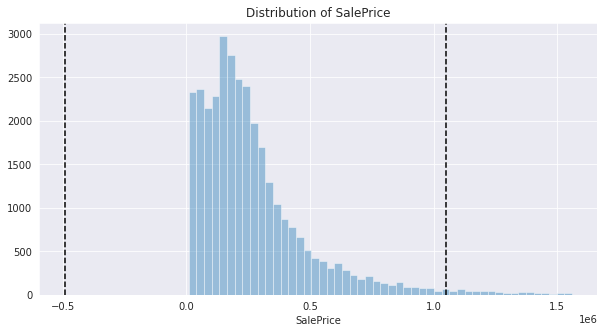

In [7]:
PlotDist('SalePrice')

Estimated λ: 0.18


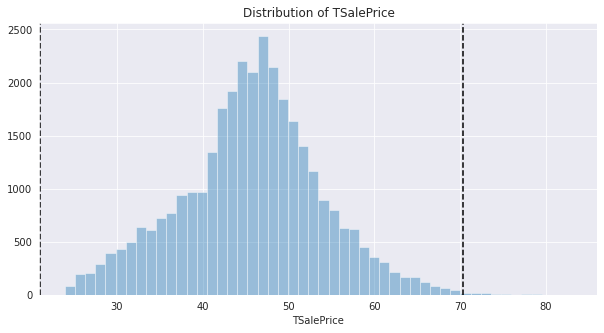

In [8]:
from scipy import stats
df['TSalePrice'], λ, (ci_l, ci_u) = stats.boxcox(df['SalePrice'], lmbda = None, alpha = 0.05)
print(f"Estimated λ: {λ:0.2f}")
PlotDist('TSalePrice')

# **Market Value by Location** 


**Administrative Blocks**
* There exist a total of 38 Townships in Cook County, including Chicago City
* The 14 digit [Property Index Numbers](https://www.cookcountyclerk.com/service/about-property-index-number-pin) can be used to break down geography by administrative blocks


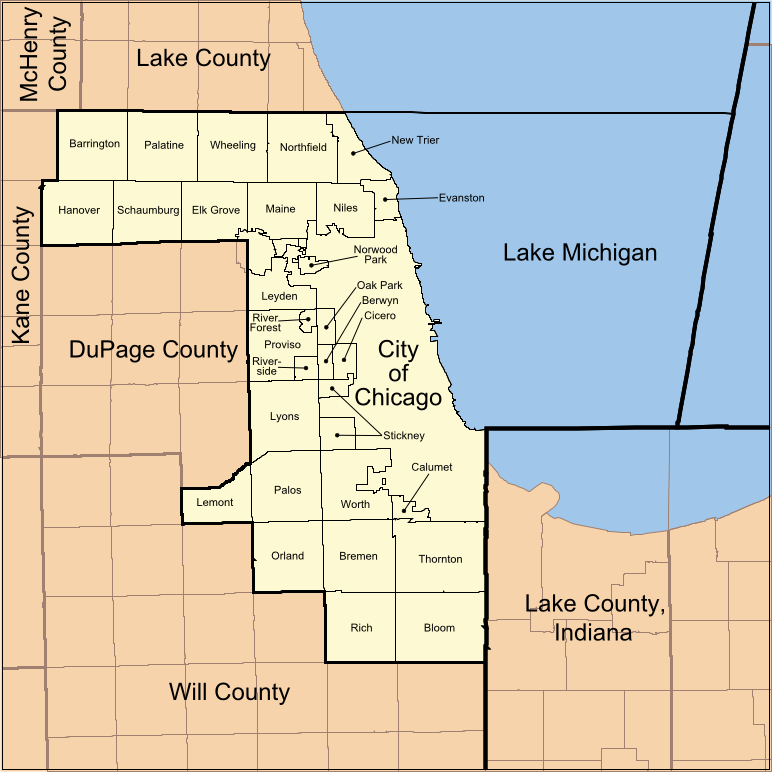

In [9]:
from PIL import Image
Image.open(PATH + 'map.png')

Distinct Values Taken: 38
Top 5 township_name: ['Calumet' 'Thornton' 'Bloom' 'Hyde Park' 'Lake']
Bottom 5 township_name: ['Northfield' 'River Forest' 'Lake View' 'New Trier' 'North Chicago']


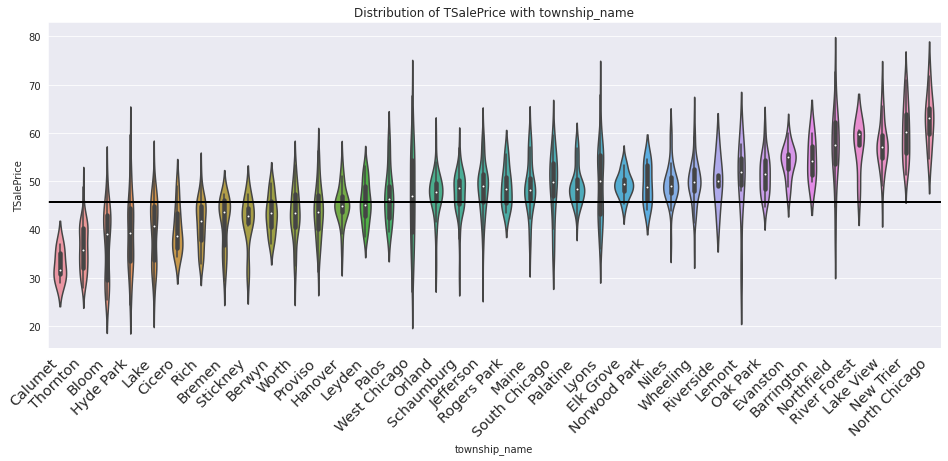

In [10]:
plt.rcParams["figure.figsize"] = (16,6)
CatPlot('township_name')

In [11]:
df['PIN'] = df["PIN"].astype(str).str.pad(14, side ='left', fillchar='0') # Permanent Identification Number
df['PIN1']=df.PIN.str[0:2]; print('No of Area/Sequential-Townships:', df.PIN1.nunique())  
df['PIN2']=df.PIN.str[0:4]; print('No of SubArea:', df.PIN2.nunique())
df['PIN3']=df.PIN.str[0:7]; print('No of Blocks:', df.PIN3.nunique())
df['PIN4']=df.PIN.str[0:10]; print('No of Parcels/Homes:', df.PIN4.nunique())

No of Area/Sequential-Townships: 33
No of SubArea: 862
No of Blocks: 21018
No of Parcels/Homes: 31907


Distinct Values Taken: 862
Top 5 PIN2: ['3229' '2906' '3230' '2909' '2824']
Bottom 5 PIN2: ['1830' '1704' '1432' '0527' '1428']


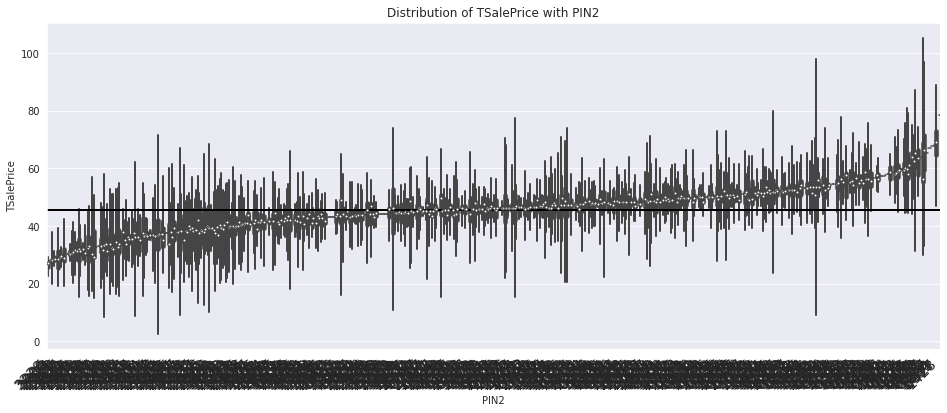

In [12]:
CatPlot('PIN2')

**Geographical Clusters**
* GIS Data can be used to produce a map of House locations and a Map of Cook County
* Using Lat/Long co-ordinates for Sale location we can obtain clusters/hubs of Sale activity.
* These clusters/hubs can be new geographical divisions and act as ordinal features

In [0]:
# Load Street Map
#%pip install geopandas
import geopandas as geo
from shapely.geometry import Point, Polygon
streetMapPATH = '/content/drive/My Drive/Projects/Machine Learning/Real World Problems/Residential Property Valuation/Data/tl_2018_17031_addrfeat.shp'
streetMap = geo.read_file(streetMapPATH)

# Cluster Detection - 8, 16, 32 Clusters
df_cluster = df[['PIN', 'DeedNo', 'TSalePrice', 'Longitude', 'Latitude']].dropna()
from sklearn.cluster import KMeans
df_cluster = df[['PIN', 'DeedNo', 'TSalePrice', 'Longitude', 'Latitude']].dropna()
df_cluster['xy_kmeans8'] = KMeans(n_clusters=8, random_state=42).fit(df_cluster[['Latitude', 'Longitude']]).labels_
df_cluster['xy_kmeans16'] = KMeans(n_clusters=16, random_state=42).fit(df_cluster[['Latitude', 'Longitude']]).labels_
df_cluster['xy_kmeans32'] = KMeans(n_clusters=32, random_state=42).fit(df_cluster[['Latitude', 'Longitude']]).labels_

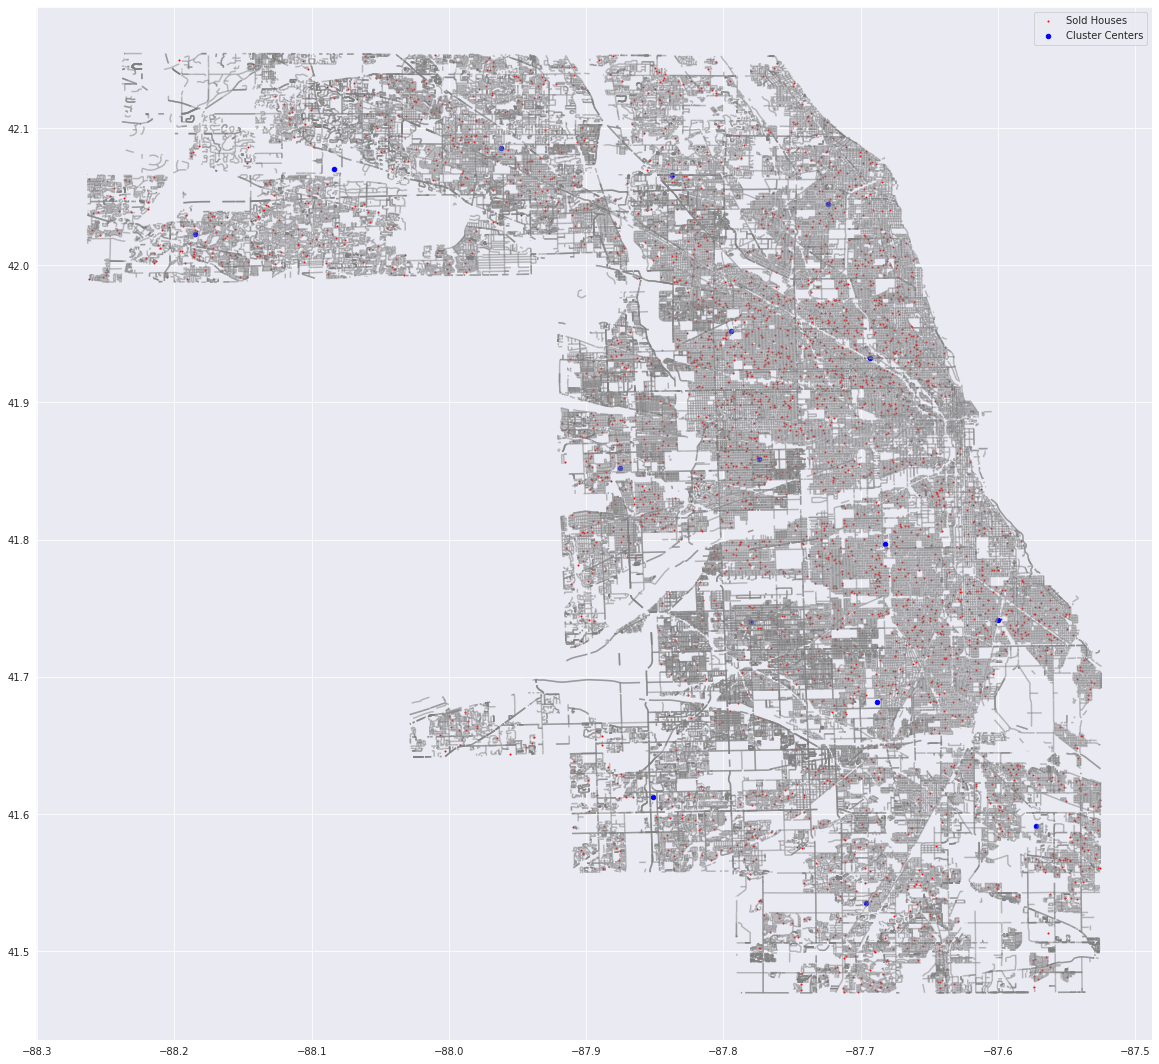

In [14]:
# Geodataframes 
df_cluster_centroids = df_cluster.groupby('xy_kmeans16').mean()
geometry1 = [Point(xy) for xy in zip(df_cluster['Longitude'], df_cluster['Latitude'])]
geometry2 = [Point(xy) for xy in zip(df_cluster_centroids['Longitude'], df_cluster_centroids['Latitude'])]
gdf1 = geo.GeoDataFrame(df_cluster, crs = {'init':'epsg:4326'}, geometry=geometry1)
gdf2 = geo.GeoDataFrame(df_cluster_centroids, crs = {'init':'epsg:4326'}, geometry=geometry2)

# Plot
fig, ax = plt.subplots(figsize = (20,20))
streetMap.plot(ax = ax, alpha=0.5, color = 'grey')
gdf1.sample(frac = 0.1).plot(ax = ax, markersize = 1, color = 'red', label = 'Sold Houses')
gdf2.plot(ax = ax, markersize = 20, color = 'blue', label = 'Cluster Centers')
plt.legend()
plt.show()

In [0]:
# Add features to dataset
df = df.merge(df_cluster.drop('geometry', axis = 1), on = ['PIN', 'DeedNo', 'TSalePrice'])

In [0]:
# Scaling Price & Lat/Long
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
X = df_cluster[['Latitude', 'Longitude', 'TSalePrice']]
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

Distinct Values Taken: 16
Top 5 xy_kmeans16: [11 15 10  3  6]
Bottom 5 xy_kmeans16: [12  5  2  4  0]


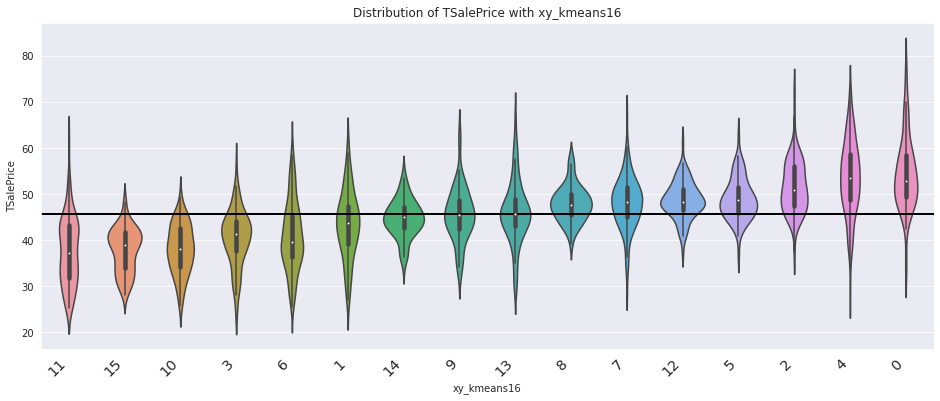

In [23]:
CatPlot('xy_kmeans16')

**Location Model**

* We are able to explain above 60% of variation in Sale Price with Location Attributes
* However there is still variation within same locations. 
* Location cannot explain extreme Sales

Train R Square: 0.641
Test R Square: 0.635


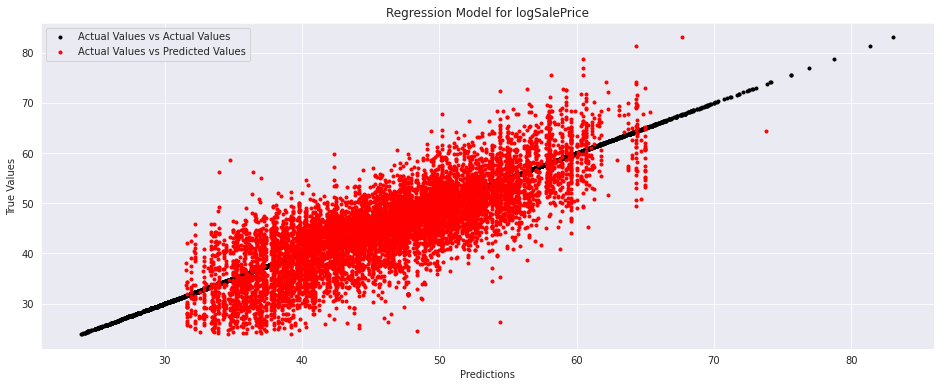

In [22]:
# Other measures
for i in ['Floodplain', 'RoadProximity', 'OHareNoise']:
    df[i].fillna(0, inplace = True)

LOCATION = ['township_name', 'PIN2', 'xy_kmeans16', 'Floodplain', 'RoadProximity', 'OHareNoise']
df.Floodplain.fillna(0, inplace = True)
modelLOCATION = NNReg(LOCATION, H = (500,), N = 200, α = 0.1, L1 = 1, plot = True)